# ML Data Preparation

## Import Dependencies

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from glob import glob
import argparse
from tqdm import tqdm
from sklearn.neighbors import BallTree

import warnings
warnings.filterwarnings('ignore')

## Define Files and Directory Paths

In [18]:
# Main directory containing raw raster and vector datasets
MAIN_DATA_DIR = r'/beegfs/halder/DATA'

# GitHub-linked project directory where processed data and results are stored
PROJECT_DATA_DIR = r'/beegfs/halder/GITHUB/Landscape-Analysis/data'

# Temporary directory used for storing intermediate files
TEMP_DIR = os.path.join(PROJECT_DATA_DIR, 'TEMP')

# Output directory
OUT_DIR = os.path.join(PROJECT_DATA_DIR, 'OUTPUT')

## Load Hexagonal Grid for Germany

In [19]:
# Define the distance and epsg
DISTANCE = 10
EPSG = 25832
CROP = 'WW'
CROP_CODE = 1110

# Path to grid shapefile
GRID_PATH = os.path.join(PROJECT_DATA_DIR, 'VECTOR', f'DE_Hexbins_{DISTANCE}sqkm_EPSG_{EPSG}.shp')

# Load grid as a GeoDataFrame and retain relevant columns
grids_gdf = gpd.read_file(GRID_PATH)
grids_gdf = grids_gdf[['id', 'geometry']]
grids_gdf['id'] = grids_gdf['id'].astype(int)

print('Grids Shape:', grids_gdf.shape)
print('Successfully read the grids!')

Grids Shape: (4430, 2)
Successfully read the grids!


## Post-process Landscape Metrics

**Landscape Metrics**

| **Metric**                      | **Category**      | **What It Captures**                       | **Why It's Useful**                                                                   |
| ------------------------------- | ----------------- | ------------------------------------------ | ------------------------------------------------------------------------------------- |
| `shannon_diversity_index`       | **Diversity**     | Diversity and evenness of land cover types | Captures landscape heterogeneity that can impact crop resilience, pest pressure, etc. |
| `patch_density`                 | **Fragmentation** | Number of patches per unit area            | Measures how broken up the landscape is — affects machinery use, edge exposure        |
| `euclidean_nearest_neighbor_mn` | **Connectivity**  | Mean distance to nearest neighbor patch    | Indicates landscape continuity, important for pollination, water flow, pest dynamics  |


In [20]:
# Read the landscape metrics
file_path = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'landscape_metrics.csv')
landscape_metrics = pd.read_csv(file_path)

imp_landscape_metrics = [
    'shannon_diversity_index',                
    'patch_density',
    'euclidean_nearest_neighbor_mn',
]

landscape_metrics = landscape_metrics[['id'] + imp_landscape_metrics]

# Rename the columns
landscape_metrics.rename(columns={
    'shannon_diversity_index': 'landscape_shannon_diversity_index',
    'patch_density': 'landscape_patch_density',
    'euclidean_nearest_neighbor_mn': 'landscape_euclidean_nearest_neighbor_mn'
}, inplace=True)

print(landscape_metrics.shape)
landscape_metrics.head()

(4430, 4)


,id,landscape_shannon_diversity_index,landscape_patch_density,landscape_euclidean_nearest_neighbor_mn
0,1122,1.154475,31.634200,55.804635
1,1125,1.328503,50.540802,44.479355
2,1124,1.153383,33.020145,52.084961
3,1127,1.500198,77.809274,40.682265
4,1126,1.323453,45.933075,44.741108


## Post-process Landscape Class Metrics

| **Group Name**                               | **Prefix**       | **LULC Classes (Code)**                                      | **Features**        | **Description**                                | **Influence on Crop Yield**                                                                                |
| -------------------------------------------- | ---------------- | ------------------------------------------------------------ | ------------------- | ---------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| 🌾 **Cropland**                              | `cropland`       | Cropland (40)                                                | `*_prop_landscape`  | % of landscape covered by cropland             | Directly represents cultivated area; higher proportion usually means higher yield potential                |
|                                              |                  |                                                              | `*_patch_density`   | Average number of cropland patches per area    | High patch density may indicate fragmentation, possibly reducing yield                                     |
|                                              |                  |                                                              | `*_edge_density`    | Edge length per area of cropland               | Edges can affect crop microclimate and pest dynamics; moderate edge density may be beneficial              |
|                                              |                  |                                                              | `*_shape_index`     | Shape complexity of cropland patches           | Compact shapes favor efficient management; complex shapes may increase edge effects                        |
|                                              |                  |                                                              | `*_enn_mn`          | Mean nearest neighbor distance of patches      | Greater distances can imply isolated fields, impacting pollination and management                          |
|                                              |                  |                                                              | `*_total_core_area` | Core (interior) cropland area                  | Larger core areas correspond to uninterrupted productive zones, beneficial for yield                       |
| 🌿 **Productive / Agronomically Supportive** | `productive`     | Tree Cover (10), Grassland (30)                              | `*_prop_landscape`  | % of landscape from productive natural classes | Supports soil health, microclimate regulation, biodiversity — indirectly boosts yield potential            |
|                                              |                  |                                                              | `*_patch_density`   | Avg. number of patches per area                | Fragmentation may reduce beneficial ecosystem services                                                     |
|                                              |                  |                                                              | `*_edge_density`    | Edge length per area                           | Balanced edge densities help ecological interactions                                                       |
|                                              |                  |                                                              | `*_shape_index`     | Shape complexity                               | Compact patches better support ecosystem function                                                          |
|                                              |                  |                                                              | `*_enn_mn`          | Mean distance between patches                  | Connectivity improves ecosystem service flows                                                              |
|                                              |                  |                                                              | `*_total_core_area` | Core area of productive patches                | Larger core natural areas improve habitat and microclimate benefits                                        |
| 🌊 **Buffering / Natural Buffers**           | `buffering`      | Wetlands (90), Water (80), Shrubland (20), Moss/Lichen (100) | `*_prop_landscape`  | % of landscape covered by buffers              | Buffers regulate water, control pests, and mitigate environmental stress, indirectly supporting crop yield |
|                                              |                  |                                                              | `*_patch_density`   | Number of buffer patches per area              | More patches can increase connectivity but excessive fragmentation reduces function                        |
|                                              |                  |                                                              | `*_edge_density`    | Edge length of buffer zones                    | Edges enhance species exchange but also risk pest spillover                                                |
|                                              |                  |                                                              | `*_shape_index`     | Shape complexity                               | Irregular shapes can improve ecological buffering                                                          |
|                                              |                  |                                                              | `*_enn_mn`          | Distance between buffer patches                | Closer patches increase landscape permeability                                                             |
|                                              |                  |                                                              | `*_total_core_area` | Core (interior) buffer area                    | Larger core areas enhance buffering services                                                               |
| 🏙️ **Non-Productive / Yield-Limiting**      | `non_productive` | Built-up (50), Snow/Ice (70), Bare (60)                      | `*_prop_landscape`  | % of landscape in non-productive classes       | Land not usable for agriculture; competes for space and resources, reduces yield potential                 |
|                                              |                  |                                                              | `*_patch_density`   | Number of non-productive patches per area      | Fragmentation of disturbance areas can exacerbate negative impacts                                         |
|                                              |                  |                                                              | `*_edge_density`    | Edge length of non-productive patches          | High edge exposure can degrade adjacent productive land                                                    |
|                                              |                  |                                                              | `*_shape_index`     | Shape complexity                               | Irregular shapes increase fragmentation impacts                                                            |
|                                              |                  |                                                              | `*_enn_mn`          | Distance between non-productive patches        | Closely packed non-productive areas may isolate cropland                                                   |
|                                              |                  |                                                              | `*_total_core_area` | Core area of non-productive patches            | Large cores reduce contiguous agricultural areas and disrupt local ecology                                 |


In [21]:
# Define the path to the class-level landscape metrics file
file_path = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'class_metrics.csv')

# Read the class-level landscape metrics CSV file into a DataFrame
class_metrics = pd.read_csv(file_path)

# Define LULC class groupings based on ecological/agronomic function
productive_classes = [10, 30]             # 🌿 Productive: tree cover, grassland
cropland_classes = [40]                   # 🌾 Cropland as a separate group
buffering_classes = [90, 80, 20, 100]    # 🌊 Buffering: wetlands, water bodies, shrubland, moss/lichen
non_productive_classes = [50, 70, 60]    # 🏙️ Non-Productive: built-up, snow/ice, bare

# Filter class_metrics to extract only rows corresponding to each group
productive_df = class_metrics[class_metrics['class_val'].isin(productive_classes)]
cropland_df = class_metrics[class_metrics['class_val'].isin(cropland_classes)]
buffering_df = class_metrics[class_metrics['class_val'].isin(buffering_classes)]
non_productive_df = class_metrics[class_metrics['class_val'].isin(non_productive_classes)]

def aggregate_group_features(df, prefix):
    """
    Aggregates selected landscape metrics for a given group of LULC classes.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing class-level metrics for the group.
        prefix (str): A string prefix indicating the group name (e.g., 'productive').
    
    Returns:
        pd.DataFrame: Aggregated metrics per landscape unit (by 'id'), with prefixed column names.
    """
    data_dict = {
        f"{prefix}_prop_landscape": df[['id', 'proportion_of_landscape']].groupby(by='id').sum(),
        f"{prefix}_patch_density": df[['id', 'patch_density']].groupby(by='id').mean(),
        f"{prefix}_edge_density": df[['id', 'edge_density']].groupby(by='id').mean(),
        f"{prefix}_shape_index": df[['id', 'landscape_shape_index']].groupby(by='id').mean(),
        f"{prefix}_enn_mn": df[['id', 'euclidean_nearest_neighbor_mn']].groupby(by='id').mean(),
        f"{prefix}_total_core_area": df[['id', 'total_core_area']].groupby(by='id').sum(),
    }

    result = pd.DataFrame()
    for key, val in data_dict.items():
        col = val.columns[0]
        data = val.reset_index()
        data.rename(columns={col: key}, inplace=True)

        if result.empty:
            result = data
        else:
            result = pd.merge(left=result, right=data, on='id', how='inner')

    return result

# Aggregate metrics for each group
productive_df = aggregate_group_features(productive_df, 'productive')
cropland_df = aggregate_group_features(cropland_df, 'cropland')
buffering_df = aggregate_group_features(buffering_df, 'buffering')
non_productive_df = aggregate_group_features(non_productive_df, 'non_productive')

# Combine all groups into a single DataFrame
landscape_class_metrics = pd.DataFrame()

for df in [productive_df, buffering_df, non_productive_df, cropland_df]:
    if landscape_class_metrics.empty:
        landscape_class_metrics = df
    else:
        landscape_class_metrics = pd.merge(left=landscape_class_metrics, right=df, on='id', how='outer')

# Fill NaN values with 0 (for cases where some groups might be missing in certain 'id's)
landscape_class_metrics.fillna(0, inplace=True)

# Drop the other cropland metrics
landscape_class_metrics.drop(
    columns=['cropland_patch_density','cropland_edge_density', 'cropland_shape_index', 
             'cropland_enn_mn', 'cropland_total_core_area'],
    inplace=True
)

# Display the shape and preview the final DataFrame
print(landscape_class_metrics.shape)
landscape_class_metrics.head()

(4430, 20)


,id,productive_prop_landscape,productive_patch_density,productive_edge_density,productive_shape_index,productive_enn_mn,productive_total_core_area,buffering_prop_landscape,buffering_patch_density,buffering_edge_density,buffering_shape_index,buffering_enn_mn,buffering_total_core_area,non_productive_prop_landscape,non_productive_patch_density,non_productive_edge_density,non_productive_shape_index,non_productive_enn_mn,non_productive_total_core_area,cropland_prop_landscape
0,36,66.924014,20.910448,98.801061,40.844269,38.697798,4907.296290,4.993382,1.547639,6.384545,12.456780,115.390648,374.099959,18.179209,8.379194,42.998582,30.769256,71.822802,1183.110909,9.903395
1,37,65.912363,20.623131,114.941771,47.218656,35.624830,4671.011257,6.134955,0.592586,4.049777,7.325027,745.363453,473.947837,12.888202,8.530923,34.646129,27.538756,109.011714,810.042928,15.064480
2,44,47.295151,19.895880,91.815418,45.670719,37.720159,3287.680498,0.537957,0.130831,0.495545,3.519128,585.093270,40.193093,9.722838,4.646412,24.705975,23.309886,107.992481,622.920007,42.444054
3,45,36.584439,22.082727,88.464218,48.515252,36.279117,2396.667857,0.063775,0.088546,0.177431,2.668403,217.050941,3.279635,8.849854,5.081799,27.345176,24.200872,315.757316,523.012696,54.501932
4,46,54.131822,27.474421,125.982491,57.798634,35.002341,3574.818790,0.900899,0.686861,2.192191,8.181882,275.065846,58.974004,28.511596,7.261097,58.683867,31.082442,84.446079,1928.128446,16.455684


## Post-process Cropland Metrics

In [22]:
# Read the crop metrics
file_paths = glob(os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'crop_landscape_metrics*'))
crop_metrics_dfs = [pd.read_csv(fp) for fp in file_paths]
crop_metrics_df = pd.concat(crop_metrics_dfs, ignore_index=True)

# Calculate crop shannon diversity index and patch density
crop_metrics_df = crop_metrics_df[['id', 'shannon_diversity_index', 'patch_density', 'edge_density', 
                                   'landscape_shape_index', 'euclidean_nearest_neighbor_mn', 'total_core_area']]
crop_metrics_df = crop_metrics_df.groupby(by='id').mean().reset_index()
crop_metrics_df.rename(columns={
    'shannon_diversity_index': 'cropland_shannon_diversity_index',
    'patch_density': 'cropland_patch_density',
    'edge_density': 'cropland_edge_density', 
    'landscape_shape_index': 'cropland_shape_index', 
    'euclidean_nearest_neighbor_mn': 'cropland_enn_mn', 
    'total_core_area': 'cropland_total_core_area'
}, inplace=True)
crop_metrics_df.fillna(0, inplace=True)

# Combine the crop class metrics
crop_class_metrics_paths = glob(os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'crop_class_metrics_*.csv'))
crop_class_metrics_dfs = [pd.read_csv(fp) for fp in crop_class_metrics_paths]
crop_class_metrics_df = pd.concat(crop_class_metrics_dfs, axis=0, ignore_index=True)
crop_class_metrics_df = crop_class_metrics_df[crop_class_metrics_df['class_val']==CROP_CODE]

crop_area_proportion = crop_class_metrics_df[['id', 'proportion_of_landscape']].groupby(by=['id']).mean().reset_index()
crop_area_proportion.rename(columns={'proportion_of_landscape': 'proportion_of_crop'}, inplace=True)

# Drop hexbins with crop area less than 5%
crop_area_proportion = crop_area_proportion[crop_area_proportion['proportion_of_crop']>=5]

# Merge the 'proportion_of_crop' with the grids_gdf
grids_gdf = grids_gdf[grids_gdf['id'].isin(crop_area_proportion['id'].unique())]

# Extract the crop specific intensity
file_path = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'crop_intensity.csv')
crop_intensity_df = pd.read_csv(file_path)
crop_intensity_df = crop_intensity_df[['id', 'normalized_crop_intensity']]

print(crop_metrics_df.shape)
crop_metrics_df.head()

(4364, 7)


,id,cropland_shannon_diversity_index,cropland_patch_density,cropland_edge_density,cropland_shape_index,cropland_enn_mn,cropland_total_core_area
0,36,1.602173,28.394166,41.529186,14.971141,470.507002,467.005805
1,37,1.592927,35.606957,49.272245,25.022763,352.246215,918.978292
2,44,1.822850,31.724447,83.178706,36.536151,228.700944,2809.400683
3,45,1.875360,24.715392,99.388072,34.120646,189.793440,3856.026400
4,46,1.792241,24.594733,59.558585,18.803639,409.050184,1002.644020


## Post-process Cropland SQR and SWF

In [23]:
# Read the Soil Quality Rating data
file_path = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'soil_quality_rating_(sqr).csv')
sqr_df = pd.read_csv(file_path)
sqr_df.rename(columns={'SQR_MEAN': 'sqr_mean', 'SQR_STD': 'sqr_std'}, inplace=True)

# Read the Small Woody Features precentage data
file_path = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'small_woody_featuers_percentage.csv')
swf_df = pd.read_csv(file_path)
swf_df = swf_df[['id', 'SWF_area_perc']]
swf_df.rename(columns={'SWF_area_perc': 'swf_area_perc'}, inplace=True)

print(sqr_df.shape, swf_df.shape)
sqr_df.head()

(4084, 3) (4406, 2)


,id,sqr_mean,sqr_std
0,1122,68.750000,0.000000
1,1125,66.049360,11.364379
2,1124,67.609614,3.016780
3,1127,76.888184,19.299734
4,1126,79.745187,8.906049


## Post-process Topographical Data

In [24]:
# Read the topo mean data
file_paths = glob(os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'Topo_Stats', 'DEM_Stat_Mean_*'))
topo_mean_dfs = [pd.read_csv(fp) for fp in file_paths]
topo_mean_df = pd.concat(topo_mean_dfs, ignore_index=True)
topo_mean_df = topo_mean_df[['id', 'Elevation', 'Slope']]
topo_mean_df.rename(columns={'Elevation': 'elevation_mean', 'Slope': 'slope_mean'}, inplace=True)

# Read the topo std data
file_paths = glob(os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'Topo_Stats', 'DEM_Stat_STD_*'))
topo_std_dfs = [pd.read_csv(fp) for fp in file_paths]
topo_std_df = pd.concat(topo_std_dfs, ignore_index=True)
topo_std_df = topo_std_df[['id', 'Elevation', 'Slope']]
topo_std_df.rename(columns={'Elevation': 'elevation_std', 'Slope': 'slope_std'}, inplace=True)

# Merge both the data
topo_df = pd.merge(left=topo_mean_df, right=topo_std_df, on='id', how='inner')
print(topo_df.shape)
topo_df.head()

(4430, 5)


,id,elevation_mean,slope_mean,elevation_std,slope_std
0,4738,113.066613,2.187786,13.296457,2.938200
1,4741,166.705786,2.426950,11.611382,3.229647
2,4740,149.696216,3.051821,14.290831,3.799614
3,4743,231.351278,4.331055,21.832623,4.222821
4,4742,192.714848,2.680768,18.007386,3.212849


## Merge All the Static Variables

In [25]:
# Merge all the dataframes
static_gdf = grids_gdf.copy()

for df in [landscape_metrics, landscape_class_metrics, crop_metrics_df, sqr_df, swf_df, topo_df]:
    static_gdf = pd.merge(left=static_gdf, right=df, on='id', how='left')

static_gdf.sort_values(by='id', inplace=True)
print(static_gdf.shape)
static_gdf.head()

(3882, 37)


,id,geometry,landscape_shannon_diversity_index,landscape_patch_density,landscape_euclidean_nearest_neighbor_mn,productive_prop_landscape,productive_patch_density,productive_edge_density,productive_shape_index,productive_enn_mn,...,cropland_shape_index,cropland_enn_mn,cropland_total_core_area,sqr_mean,sqr_std,swf_area_perc,elevation_mean,slope_mean,elevation_std,slope_std
448,36,"POLYGON ((280447.385 5746309.119, 283334.136 5...",1.417890,70.960395,46.985762,66.924014,20.910448,98.801061,40.844269,38.697798,...,14.971141,470.507002,467.005805,57.621872,2.798603,0.382004,33.302231,3.463591,27.180850,3.899358
447,37,"POLYGON ((280447.385 5736309.119, 283334.136 5...",1.461738,72.726407,45.664981,65.912363,20.623131,114.941771,47.218656,35.624830,...,25.022763,352.246215,918.978292,73.500000,1.500000,0.033255,23.823446,2.919810,21.403559,3.501822
444,45,"POLYGON ((280447.385 5656309.119, 283334.136 5...",1.175647,58.810275,42.835139,36.584439,22.082727,88.464218,48.515252,36.279117,...,34.120646,189.793440,3856.026400,86.529746,12.393370,2.177159,60.307668,1.982828,11.421982,2.758052
446,46,"POLYGON ((280447.385 5646309.119, 283334.136 5...",1.401987,76.697500,43.954853,54.131822,27.474421,125.982491,57.798634,35.002341,...,18.803639,409.050184,1002.644020,NaN,NaN,0.163621,95.037242,4.133264,17.808571,4.020593
445,47,"POLYGON ((280447.385 5636309.119, 283334.136 5...",1.347137,61.963301,42.671384,47.692763,21.204962,110.182539,53.661445,37.774889,...,27.131085,302.925914,2639.699449,91.464706,2.817788,0.254121,152.662870,4.061868,29.728284,3.593268


In [26]:
# Fill the NaN values
cols_to_be_imputed = ['sqr_mean', 'sqr_std', 'elevation_mean', 
                      'slope_mean', 'elevation_std', 'slope_std']

nan_cols = static_gdf.isnull().sum()
nan_cols = nan_cols[nan_cols>0].index

for col in nan_cols:
    if col not in cols_to_be_imputed:
        static_gdf[col] = static_gdf[col].fillna(0)

    else:
        col_gdf = static_gdf[['id', col, 'geometry']]
        col_gdf_known = col_gdf[col_gdf[col].notna()].copy()
        col_gdf_missing = col_gdf[col_gdf[col].isna()].copy()

        # Get coordinates (Y = northing, X = easting)
        known_coords = np.array(list(col_gdf_known.geometry.centroid.apply(lambda geom: (geom.y, geom.x))))
        missing_coords = np.array(list(col_gdf_missing.geometry.centroid.apply(lambda geom: (geom.y, geom.x))))
        
        # Build BallTree (uses Euclidean distance here because CRS is metric)
        tree = BallTree(known_coords, metric='euclidean')
        dist, indices = tree.query(missing_coords, k=1)
    
        # Assign values from nearest neighbor
        col_gdf_missing[col] = col_gdf_known.iloc[indices.flatten()][col].values
    
        gdf_imputed = pd.concat([col_gdf_known, col_gdf_missing]).sort_values(by='id')
        static_gdf[col] = gdf_imputed[col]

print(static_gdf.shape)
static_gdf.head()

(3882, 37)


,id,geometry,landscape_shannon_diversity_index,landscape_patch_density,landscape_euclidean_nearest_neighbor_mn,productive_prop_landscape,productive_patch_density,productive_edge_density,productive_shape_index,productive_enn_mn,...,cropland_shape_index,cropland_enn_mn,cropland_total_core_area,sqr_mean,sqr_std,swf_area_perc,elevation_mean,slope_mean,elevation_std,slope_std
448,36,"POLYGON ((280447.385 5746309.119, 283334.136 5...",1.417890,70.960395,46.985762,66.924014,20.910448,98.801061,40.844269,38.697798,...,14.971141,470.507002,467.005805,57.621872,2.798603,0.382004,33.302231,3.463591,27.180850,3.899358
447,37,"POLYGON ((280447.385 5736309.119, 283334.136 5...",1.461738,72.726407,45.664981,65.912363,20.623131,114.941771,47.218656,35.624830,...,25.022763,352.246215,918.978292,73.500000,1.500000,0.033255,23.823446,2.919810,21.403559,3.501822
444,45,"POLYGON ((280447.385 5656309.119, 283334.136 5...",1.175647,58.810275,42.835139,36.584439,22.082727,88.464218,48.515252,36.279117,...,34.120646,189.793440,3856.026400,86.529746,12.393370,2.177159,60.307668,1.982828,11.421982,2.758052
446,46,"POLYGON ((280447.385 5646309.119, 283334.136 5...",1.401987,76.697500,43.954853,54.131822,27.474421,125.982491,57.798634,35.002341,...,18.803639,409.050184,1002.644020,91.221074,4.749966,0.163621,95.037242,4.133264,17.808571,4.020593
445,47,"POLYGON ((280447.385 5636309.119, 283334.136 5...",1.347137,61.963301,42.671384,47.692763,21.204962,110.182539,53.661445,37.774889,...,27.131085,302.925914,2639.699449,91.464706,2.817788,0.254121,152.662870,4.061868,29.728284,3.593268


## Process Climate Data

In [27]:
# Read the Soil Quality Rating data
file_path = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'ww_climate.csv')
climate_df = pd.read_csv(file_path)
climate_df = climate_df[climate_df['id'].isin(grids_gdf['id'].unique())]
climate_df.columns = [col.lower() for col in climate_df.columns]

print(climate_df.shape)
climate_df.head()

(259524, 15)


,id,year,prcp_max,prcp_sum,prcp_var_index,tmin_min,tmin_mean,tmin_std,tmax_max,tmax_mean,tmax_std,rad_min,rad_max,rad_mean,rad_std
0,5236,1952,12.342529,382.051724,0.977735,-8.910345,3.672883,5.519303,32.500000,11.126200,7.464561,-0.999000,30.271276,10.628720,7.965649
1,5236,1953,43.341379,548.113793,0.898906,-20.568966,3.489362,6.727882,30.137931,10.897066,8.797555,1.295126,29.225161,10.677334,8.516650
2,5236,1954,21.914943,351.166667,0.924930,-19.859770,2.450131,7.713516,32.111494,10.091360,8.743224,1.295126,30.102230,10.104478,7.846785
3,5236,1955,32.422989,519.575862,0.857139,-14.837931,2.473954,7.030752,27.893103,9.639113,8.015866,1.295782,30.312379,10.147308,8.340735
4,5236,1956,40.873563,539.739080,0.833705,-26.339080,2.093497,8.044243,28.380460,9.474032,8.677793,1.295126,29.865069,10.113621,8.073084


## Process Yield Data

In [28]:
# Read the yield data
file_path = os.path.join(MAIN_DATA_DIR, 'DE_Crop_Yield', 'DE_Crop_Yield_Master.csv')
yield_df = pd.read_csv(file_path)
yield_df = yield_df[yield_df['var']=='ww']
yield_df = yield_df[['nuts_id', 'year', 'value']]
yield_df.rename(columns={'nuts_id': 'NUTS_ID', 'value': 'yield'}, inplace=True)
yield_df.dropna(inplace=True)

print(yield_df.shape)
yield_df.head()

(15784, 3)


,NUTS_ID,year,yield
9,DEF01,1979,5.29
19,DEF01,1980,5.02
29,DEF01,1981,5.74
39,DEF01,1982,6.90
49,DEF01,1983,6.32


In [32]:
# Read the evi data
file_paths = glob(os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'EVI', '*.csv'))
evi_mean_dfs = [pd.read_csv(fp) for fp in file_paths]
evi_mean_df = pd.concat(evi_mean_dfs, ignore_index=True)
evi_mean_df = evi_mean_df.dropna()

# Groupby the data by 'NUTS_ID', and 'year'
evi_mean_grouped_df = evi_mean_df.drop(columns=['id']).groupby(by=['NUTS_ID', 'year']).mean().reset_index()
evi_mean_grouped_df.rename(columns={'mean_evi': 'mean_nut_evi'}, inplace=True)

# Merge the NUTS EVI mean with the 'evi_mean_df'
evi_mean_df = pd.merge(left=evi_mean_df, right=evi_mean_grouped_df, how='inner', on=['NUTS_ID', 'year'])
evi_mean_df['evi_ratio'] = evi_mean_df['mean_evi'] / evi_mean_df['mean_nut_evi']
evi_mean_df = pd.merge(left=evi_mean_df, right=yield_df, on=['NUTS_ID', 'year'], how='inner')
evi_mean_df['distributed_yield'] = evi_mean_df['yield'] * evi_mean_df['evi_ratio']

yield_df_distibuted = evi_mean_df[['id', 'NUTS_ID', 'year', 'mean_evi', 'mean_nut_evi', 'evi_ratio', 'distributed_yield']]
print(yield_df_distibuted.shape)
yield_df_distibuted.head()

(83477, 7)


,id,NUTS_ID,year,mean_evi,mean_nut_evi,evi_ratio,distributed_yield
0,1448,DE71D,2014,0.393343,0.401819,0.978906,7.948715
1,1447,DE71D,2014,0.403275,0.401819,1.003623,8.149422
2,1531,DE723,2014,0.391878,0.404777,0.968134,7.987107
3,1530,DE723,2014,0.419044,0.404777,1.035247,8.540790
4,1533,DE71D,2014,0.413028,0.401819,1.027895,8.346507


<Axes: xlabel='mean_evi', ylabel='yield'>

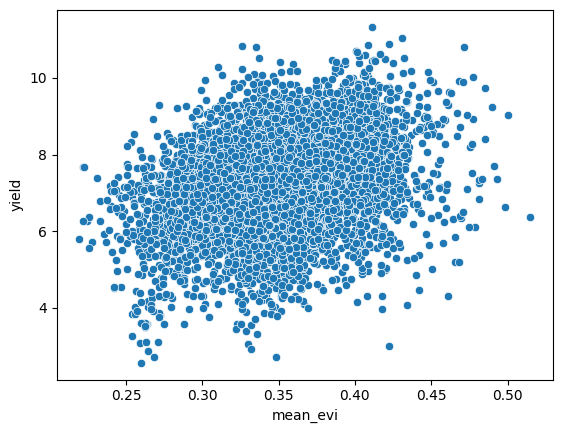

In [49]:
sns.scatterplot(data=test_df, x='mean_evi', y='yield')

In [47]:
test_yield_df = yield_df_distibuted.drop(columns=['id']).groupby(by=['NUTS_ID', 'year']).mean().reset_index()
test_df = pd.merge(left=test_yield_df, right=yield_df, on=['NUTS_ID', 'year'], how='inner') 
test_df

,NUTS_ID,year,mean_evi,mean_nut_evi,evi_ratio,distributed_yield,yield
0,DE111,2001,0.320419,0.320419,1.0,6.05,6.05
1,DE111,2002,0.314332,0.314332,1.0,6.79,6.79
2,DE111,2003,0.288492,0.288492,1.0,5.87,5.87
3,DE111,2004,0.297629,0.297629,1.0,7.68,7.68
4,DE111,2005,0.307503,0.307503,1.0,7.44,7.44
...,...,...,...,...,...,...,...
7204,DEG0M,2019,0.418887,0.418887,1.0,8.34,8.34
7205,DEG0M,2020,0.433145,0.433145,1.0,9.04,9.04
7206,DEG0M,2021,0.388915,0.388915,1.0,7.94,7.94
7207,DEG0M,2022,0.357817,0.357817,1.0,8.38,8.38


## Prepare the Final DataFrame

In [16]:
# Prepare the final dataframe
final_gdf = static_gdf.copy()

final_gdf = pd.merge(left=final_gdf, right=climate_df, on='id', how='outer')
final_gdf = pd.merge(left=final_gdf, right=yield_df_distibuted, on=['id', 'year'], how='inner')

# Reorder the columns
col_order = ['id', 'NUTS_ID', 'year', 'geometry']
for col in final_gdf.columns:
    if col not in col_order:
        col_order.append(col)

final_gdf = final_gdf[col_order]
final_gdf['year'] = final_gdf['year'].astype(int)

# Save the data
# final_gdf.to_csv(os.path.join(OUT_DIR, f'Landscape_Data_{DISTANCE}KM.csv'), index=False)

print(final_gdf.shape)
final_gdf.head()

(1151795, 53)


,id,NUTS_ID,year,geometry,landscape_shannon_diversity_index,landscape_patch_density,landscape_euclidean_nearest_neighbor_mn,productive_prop_landscape,productive_patch_density,productive_edge_density,...,tmin_mean,tmin_std,tmax_max,tmax_mean,tmax_std,rad_min,rad_max,rad_mean,rad_std,distributed_yield
0,177,DEA29,2001,"POLYGON ((280447.385 5660059.119, 281169.073 5...",1.275164,50.633356,35.429559,63.120532,17.000981,103.266872,...,6.474413,5.301266,31.350,13.942030,7.335970,1.76025,30.20350,9.949048,7.644765,9.660467
1,177,DEA29,2002,"POLYGON ((280447.385 5660059.119, 281169.073 5...",1.275164,50.633356,35.429559,63.120532,17.000981,103.266872,...,6.452189,5.814843,34.225,14.195707,7.247160,1.75925,29.85350,10.030397,7.199292,8.783925
2,177,DEA29,2003,"POLYGON ((280447.385 5660059.119, 281169.073 5...",1.275164,50.633356,35.429559,63.120532,17.000981,103.266872,...,5.692172,6.386867,35.550,14.497307,8.406264,1.75925,28.26050,11.004956,8.078055,8.787525
3,177,DEA29,2004,"POLYGON ((280447.385 5660059.119, 281169.073 5...",1.275164,50.633356,35.429559,63.120532,17.000981,103.266872,...,5.100421,5.369863,30.750,13.312290,7.010546,1.75925,28.94000,10.089957,7.322121,8.694622
4,177,DEA29,2005,"POLYGON ((280447.385 5660059.119, 281169.073 5...",1.275164,50.633356,35.429559,63.120532,17.000981,103.266872,...,5.644631,6.005391,33.750,13.636912,8.237541,1.76325,29.40525,10.146389,7.633380,9.065824
